# Detecção de Fraudes com Cartão de Crédito usando Random Forest

Este notebook tem como objetivo desenvolver e avaliar um modelo de **machine learning** para detecção de fraudes em transações com cartão de crédito, utilizando o conjunto de dados disponível no Kaggle.

O processo inclui:

- Leitura e pré-processamento do dataset
- Normalização dos dados com `StandardScaler`
- Aplicação de **undersampling** para tratar o desbalanceamento das classes
- Treinamento de um modelo `RandomForestClassifier`
- Avaliação do modelo com métricas como *AUC-ROC*, *precision*, *recall*, *f1-score*
- Ajuste manual do threshold de decisão baseado na curva *Precision-Recall*
- Visualizações para suporte à tomada de decisão

# Objetivo
Numa situação ideal o modelo deveria ser capaz de detectar sempre uma transação fraudulenta, como isso é praticamente impossível devemos focar nossos esforços em diminuir os danos para o banco e os clientes.

![image.png](./../imgs/FraudDetectionSystem.jpg)

O pipeline utilizado pelos bancos para verificar se uma transação é fraudulenta ou não é o seguinte:
1. Transação é feita no terminal, ele verifica se o pin está correto se há saldo disponível entre outras checagens. Caso esteja tudo ok ele passa para a próxima etapa.
2. A requisição de transação é verificada pelas regras de bloqueio do banco que podem ser variáveis. Basicamente consistem em bloqueios de condições determinada como a quantidade de transações iguais na última hora ou verificação de país com hora de cada transação para detectar anormalidades.
3. A transação é aprovada caso passe da etapa anterior e agora inicia-se a checagem pós-aprovação que consiste em verificar regras de pontuação de fraude determinadas pelo banco e um modelo baseado em dados para uma detecção mais elaborada.
4. Caso esses dois modelos detectem anormalidades, os investigadores analisam manualmente a transação para verificar se é realmente uma fraude ou não.

O modelo deve auxiliar os humanos na detecção de fraudes, uma vez que é praticamente impossível para uma pessoa detectar padrões de comportamento de dados. Então devemos evitar que muitos falsos positivos sejam detectados a fim de não sobrecarregar os investigadores e gerar inconveniências para os clientes, mas também evitar que falsos negativos sejam detectados pois pode gerar prejuízos imensuráveis para o banco.

Olhando deste modo, é muito importante que o modelo detecte o máximo possível de verdadeiros positivos no qual será o foco desta pesquisa.


# Informações sobre o dataset
[Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)
- 284,807 registros de transações
- 492 registros marcados como fraude

O dataset é extremamente desbalanceado e será preciso ser feito um balanceamento do mesmo. Neste notebook será utilizando o método de Undersampling onde iremos documentar os resultados e comparar com outros métodos para selecionar o modelo mais preciso para a aplicação.

# Técnica de Undersampling
Consiste em remover instâncias da classe majoritária a fim de igualar sua quantidade com a classe minoritária. Neste caso usei a seleção aleatória de amostras, mas defini um valor de seed para manter os testes consistentes. Uma das vantagens do Undersampling é quando a precisão na deteção da classe minoritária é mais importante que a geral, mas este método pode levar a perda de dados importantes. Outra vantagem é que o conjunto de dados fica menor e sistemas com menos memória se beneficiam disso além de que o treinamento do modelo é bem mais rápido.

O conjunto foi dividido em 30% para teste e os outros 70% para treinamento. Utilizei o stratify para manter a proporção entre classes igual.

Foram selecionados em torno de 350 registros aleatórios da classe majoritária igualando assim com a quantidade da minoritária.

Os resultados podem ser vistos a seguir.

# Carregamento das bibliotecas e do dataset

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time

df = pd.read_csv("../../dataset/creditcard.csv", dtype=float)
print(df)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

# Separação das features e da variável alvo

In [15]:
X = df.drop(columns=["Time", "Class"])
y = df["Class"]
X = X[y.notna()]
y = y[y.notna()]

print(X)
# print(y)

               V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V20       V21  \
0       0.239599  0.098698  0.363787  0.090794  ...  0.25141

# Normalização do campo 'Amount'

In [16]:
scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X["Amount"].values.reshape(-1, 1))

print(X['Amount'])

0         0.244964
1        -0.342475
2         1.160686
3         0.140534
4        -0.073403
            ...   
284802   -0.350151
284803   -0.254117
284804   -0.081839
284805   -0.313249
284806    0.514355
Name: Amount, Length: 284807, dtype: float64


# Divisão de treino e teste

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Undersampling no treino

Utilizando undersampling ele reduz a classe maior para se igualar com a menor. Os registros da classe maior são selecionados de forma aleatória. Assim é feito o balanceamento utilizando undersampling.

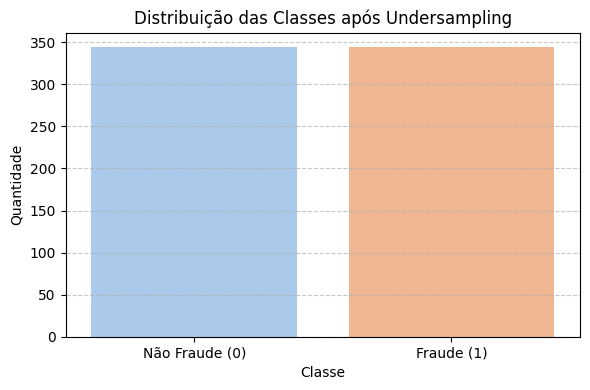

In [18]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

class_counts = y_train_resampled.value_counts().reset_index()
class_counts.columns = ['Classe', 'Quantidade']

plt.figure(figsize=(6, 4))
sns.barplot(data=class_counts, x='Classe', y='Quantidade', hue='Classe', palette='pastel', legend=False)

plt.title("Distribuição das Classes após Undersampling")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.xticks([0, 1], ["Não Fraude (0)", "Fraude (1)"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Seleção de Hiperparâmetros com Grid Search

In [ ]:
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}
scoring = 'recall'

start_time = time.time()
grid_search = GridSearchCV(estimator=base_model,
    param_grid=param_grid,
    cv=5, 
    scoring=scoring,
    n_jobs=-1,  
    verbose=2,
    return_train_score=True)
grid_search.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
print(f"Tempo de execução do GridSearchCV: {end_time - start_time:.2f} segundos")
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

print(f"\nMelhor pontuação de {scoring}: {grid_search.best_score_:.4f}")

results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')

print("\nTop 5 combinações de parâmetros:")
cols = ['params', 'mean_test_score', 'rank_test_score', 'mean_train_score']
print(results[cols].head(5))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s

[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

# Treinamento do modelo

In [20]:
best_model = grid_search.best_estimator_

# Previsões de probabilidade do teste

In [21]:
y_proba = best_model.predict_proba(X_test)[:, 1] 

# Plotagem do precision recall curve

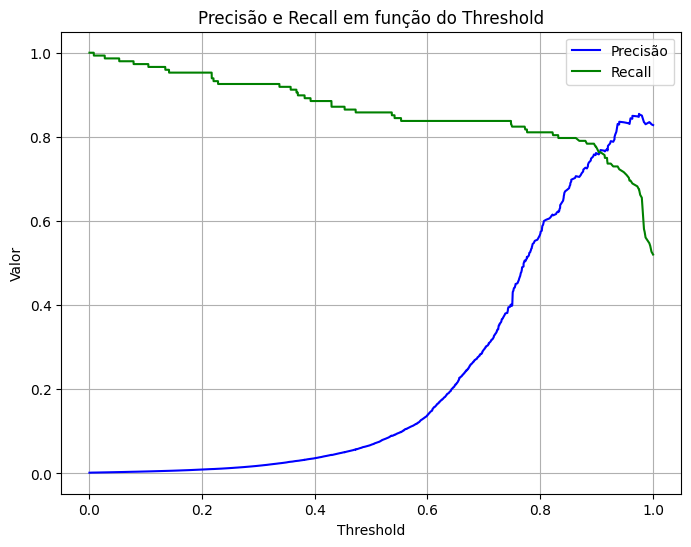

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precisão", color="b")
plt.plot(thresholds, recall[:-1], label="Recall", color="g")
plt.xlabel("Threshold")
plt.ylabel("Valor")
plt.title("Precisão e Recall em função do Threshold")
plt.legend()
plt.grid()
plt.show()

# Definição de um threshold

# Avaliação

Relatório de Classificação (com threshold ajustado):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85295
         1.0       0.70      0.80      0.75       148

    accuracy                           1.00     85443
   macro avg       0.85      0.90      0.87     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC: 0.9700


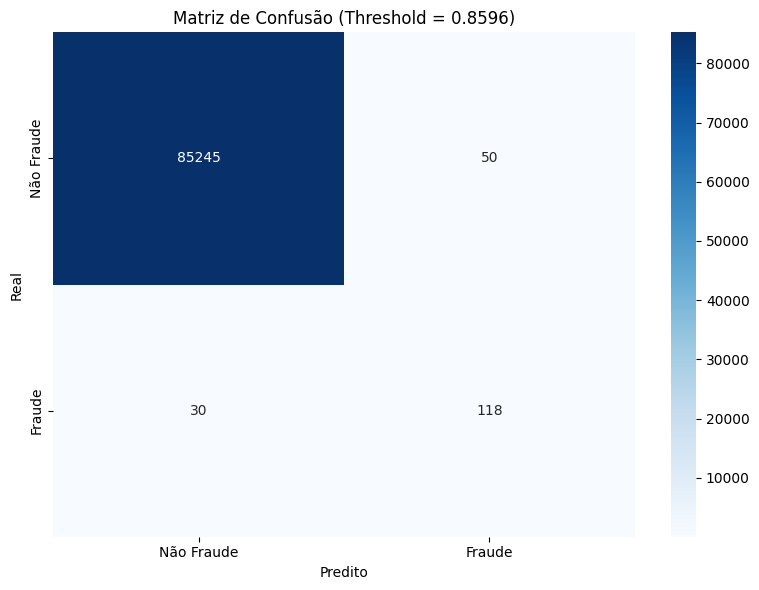

In [45]:
THRESHOLD = 0.8596
y_pred_adjusted = (y_proba >= THRESHOLD).astype(int)

print("Relatório de Classificação (com threshold ajustado):")
print(classification_report(y_test, y_pred_adjusted))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Não Fraude", "Fraude"],
            yticklabels=["Não Fraude", "Fraude"])
plt.title(f"Matriz de Confusão (Threshold = {THRESHOLD})")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

Com um treshold de 0.94 o modelo apresenta uma precisão de 0.84, recall de 0.72 e um F1-score de 0.78 para todas as vezes que o modelo acertou se uma transação era uma fraude ou não.

# Referências
https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_2_Background/FDS.html


Comparação de diferentes thresholds:
Threshold: 0.1000, Accuracy: 0.6422, Precision: 0.0047, Recall: 0.9730, F1: 0.0093
Threshold: 0.2000, Accuracy: 0.8241, Precision: 0.0093, Recall: 0.9527, F1: 0.0184
Threshold: 0.3000, Accuracy: 0.9134, Precision: 0.0182, Recall: 0.9257, F1: 0.0357
Threshold: 0.4000, Accuracy: 0.9589, Precision: 0.0361, Recall: 0.8851, F1: 0.0694
Threshold: 0.5000, Accuracy: 0.9794, Precision: 0.0680, Recall: 0.8581, F1: 0.1261
Threshold: 0.3574, Accuracy: 0.9443, Precision: 0.0279, Recall: 0.9189, F1: 0.0541
Threshold: 0.9371, Accuracy: 0.9993, Precision: 0.8308, Recall: 0.7297, F1: 0.7770
Threshold: 0.8596, Accuracy: 0.9991, Precision: 0.7024, Recall: 0.7973, F1: 0.7468


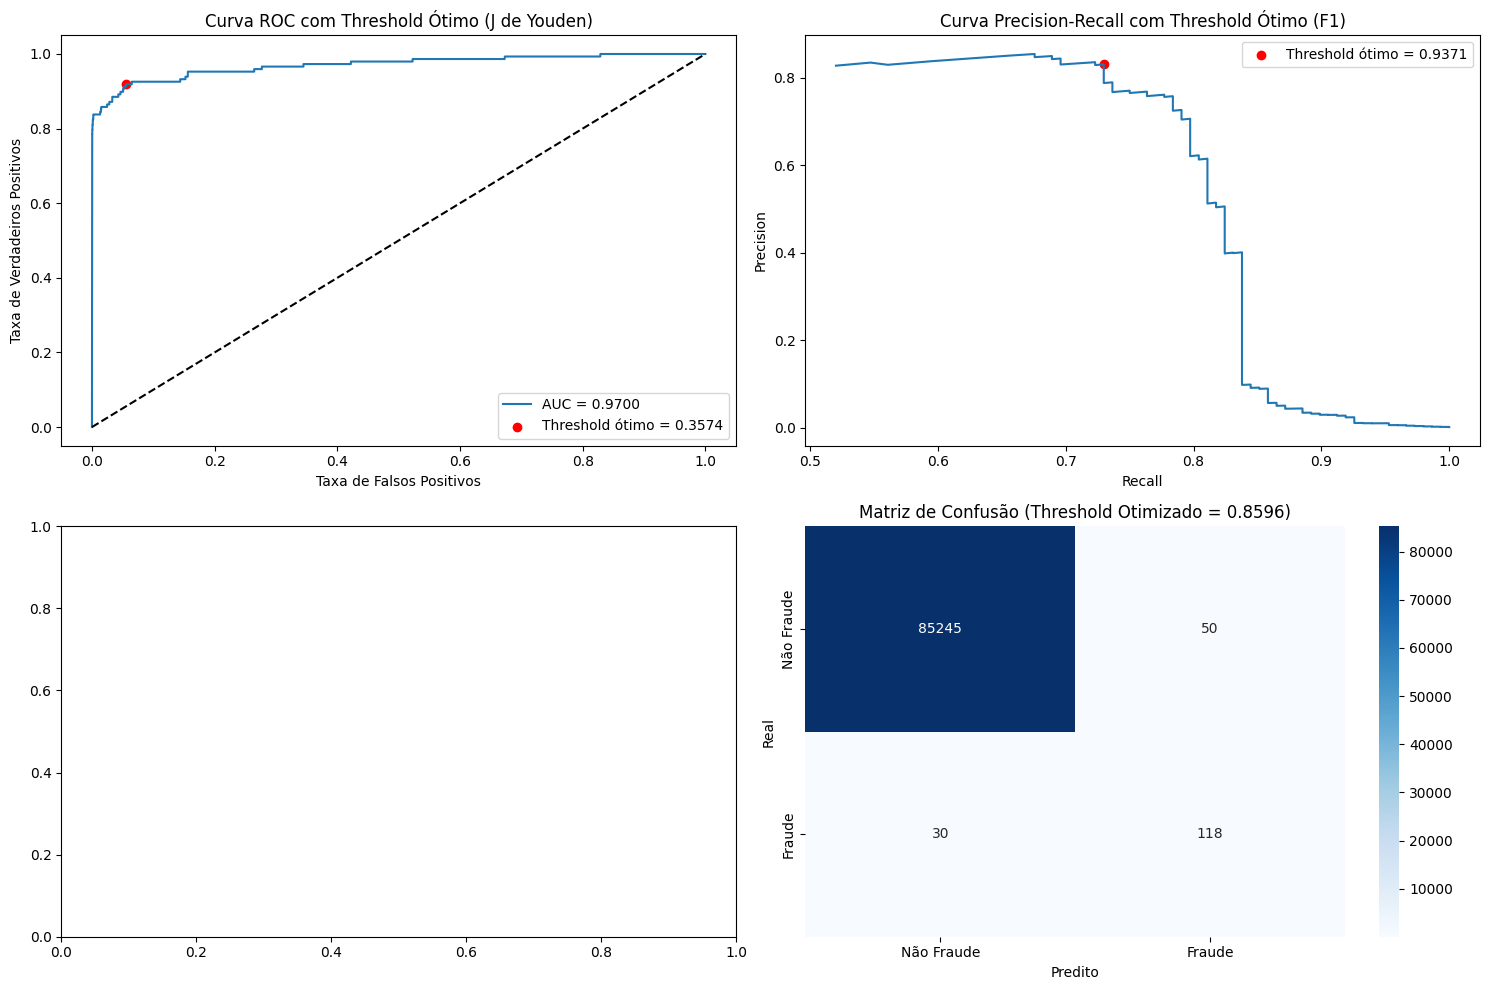


Threshold ótimo baseado na Curva ROC (J de Youden): 0.3574
Threshold ótimo baseado em F1-Score: 0.9371
Threshold ótimo baseado na análise de custo: 0.8596

Relatório de Classificação (com threshold recomendado):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85295
         1.0       0.70      0.80      0.75       148

    accuracy                           1.00     85443
   macro avg       0.85      0.90      0.87     85443
weighted avg       1.00      1.00      1.00     85443



In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, classification_report, confusion_matrix, roc_auc_score

# 1. Usando a curva ROC e o ponto J de Youden
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
# Índice do threshold que maximiza TPR - FPR (ponto J de Youden)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold_roc = thresholds_roc[optimal_idx]

# 2. Usando a curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
# Para calcular F1-score para cada threshold
f1_scores = []
for threshold in thresholds_pr:
    y_pred_temp = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)
    
optimal_idx_pr = np.argmax(f1_scores)
optimal_threshold_pr = thresholds_pr[optimal_idx_pr]

# 3. Análise customizada (exemplo com custo)
# Definir custos: por exemplo, falso negativo (fraude não detectada) é 10x mais custoso que falso positivo
cost_of_fp = 1  # Custo de um falso positivo
cost_of_fn = 10  # Custo de um falso negativo

best_threshold = None
lowest_cost = float('inf')
threshold_range = np.linspace(0.1, 0.9, 100)

for threshold in threshold_range:
    y_pred_temp = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_temp)
    
    fp = cm[0, 1]  # Falsos positivos
    fn = cm[1, 0]  # Falsos negativos
    
    total_cost = (fp * cost_of_fp) + (fn * cost_of_fn)
    
    if total_cost < lowest_cost:
        lowest_cost = total_cost
        best_threshold = threshold

# Visualizações
plt.figure(figsize=(15, 10))

# Curva ROC com threshold ótimo
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', 
            label=f'Threshold ótimo = {optimal_threshold_roc:.4f}')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC com Threshold Ótimo (J de Youden)')
plt.legend()

# Curva Precision-Recall com threshold ótimo
plt.subplot(2, 2, 2)
plt.plot(recall[:-1], precision[:-1])
precision_at_optimal = precision[np.where(thresholds_pr == optimal_threshold_pr)[0][0]]
recall_at_optimal = recall[np.where(thresholds_pr == optimal_threshold_pr)[0][0]]
plt.scatter(recall_at_optimal, precision_at_optimal, marker='o', color='red',
            label=f'Threshold ótimo = {optimal_threshold_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall com Threshold Ótimo (F1)')
plt.legend()

# Comparação de métricas por threshold
plt.subplot(2, 2, 3)
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, optimal_threshold_roc, optimal_threshold_pr, best_threshold]
metrics = []

for thresh in thresholds_to_test:
    y_pred_temp = (y_proba >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_temp)
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics.append({
        'threshold': thresh,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Exibir resultados dos thresholds
print("\nComparação de diferentes thresholds:")
for m in metrics:
    print(f"Threshold: {m['threshold']:.4f}, Accuracy: {m['accuracy']:.4f}, "
          f"Precision: {m['precision']:.4f}, Recall: {m['recall']:.4f}, F1: {m['f1']:.4f}")

# Matriz de confusão para o melhor threshold baseado em custo
plt.subplot(2, 2, 4)
y_pred_best = (y_proba >= best_threshold).astype(int)
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Fraude", "Fraude"],
            yticklabels=["Não Fraude", "Fraude"])
plt.title(f"Matriz de Confusão (Threshold Otimizado = {best_threshold:.4f})")
plt.xlabel("Predito")
plt.ylabel("Real")

plt.tight_layout()
plt.show()

print(f"\nThreshold ótimo baseado na Curva ROC (J de Youden): {optimal_threshold_roc:.4f}")
print(f"Threshold ótimo baseado em F1-Score: {optimal_threshold_pr:.4f}")
print(f"Threshold ótimo baseado na análise de custo: {best_threshold:.4f}")

# Relatório para o threshold recomendado final (escolha um dos métodos)
recommended_threshold = best_threshold  # Ou optimal_threshold_roc ou optimal_threshold_pr
y_pred_recommended = (y_proba >= recommended_threshold).astype(int)

print("\nRelatório de Classificação (com threshold recomendado):")
print(classification_report(y_test, y_pred_recommended))